In [13]:
import pandas as pd

# Read the markdown file
with open('images/GEM_LP/strategy_params.md', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Example: parse lines into a DataFrame (assuming table format in markdown)
# Adjust parsing logic if your markdown structure is different
rows = []
for line in lines:
    if '|' in line and not line.strip().startswith('|---'):
        row = [col.strip() for col in line.strip().strip('|').split('|')]
        rows.append(row)

# Assume first row is header
header = rows[0]
data = rows[1:]
df = pd.DataFrame(data, columns=header)


In [14]:
#delete row zero
df = df.drop(index=0).reset_index(drop=True)



df_AAA = df[df['strategy_name'].str.contains('AAA')]
df_AAA=df_AAA[['strategy_name','use_stops','trailing_stop','trail_percent','verbose','momentum_method','bb_period','bb_std','momentum_top_n','momentum_lookback','covariance_lookback']]

df_GEM = df[df['strategy_name'].str.contains('GEM')]
#df_GEM=df_GEM[['strategy_name','use_stops','trailing_stop','trail_percent','verbose','allow_short','momentum_method','bb_period','bb_std','risk_free_asset']]


df_GEM


,strategy_name,buy_slippage_buffer,use_stops,trailing_stop,trail_percent,verbose,allow_short,momentum_periods,min_positive_periods,treasury_threshold,maximum_positions,momentum_method,bb_period,bb_std,risk_free_asset,momentum_top_n,momentum_lookback,covariance_lookback
0,GEM2,0.03,1,1,0.05,0,0,"[10, 21, 63, 126]",3,0,6,bollinger,20,2,cash,nan,nan,nan
2,GEM1,0.03,0,1,0.05,0,0,"[10, 21, 63, 126]",3,0,6,simple,20,2,cash,nan,nan,nan
3,GEM3,0.03,1,1,0.05,0,0,"[10, 21, 63, 126]",3,0,6,simple,20,2,cash,nan,nan,nan


In [19]:
import yfinance as yf
import pandas as pd
tickers = ['UCO']
data = yf.download(tickers, start='2020-06-01', end='2021-12-31')

C:\Users\nunor\AppData\Local\Temp\ipykernel_3900\2030897997.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-06-01', end='2021-12-31')
[*********************100%***********************]  1 of 1 completed



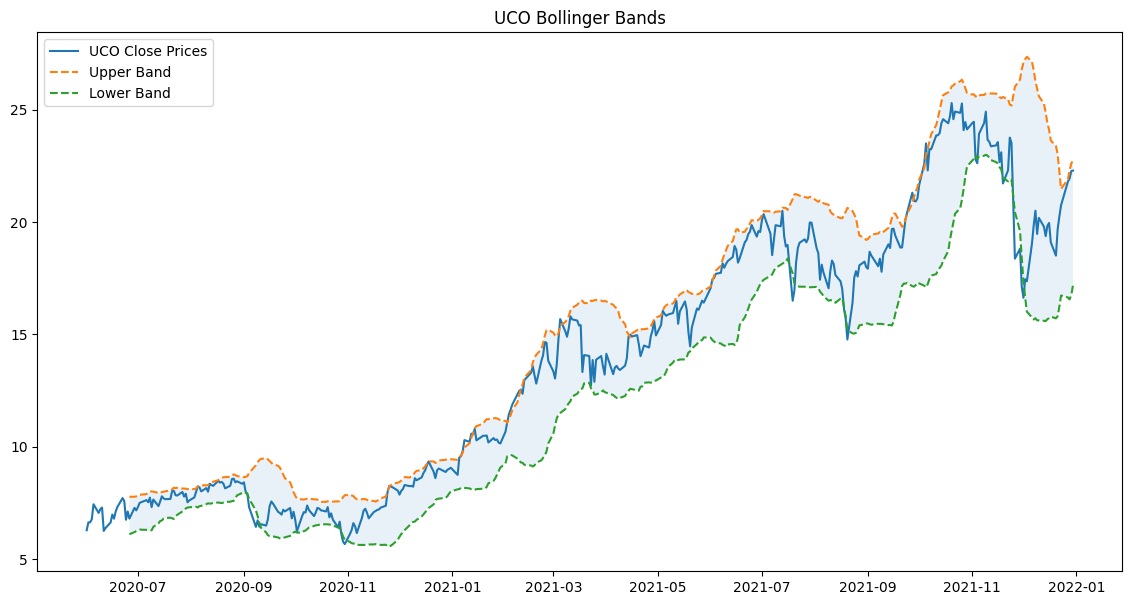

In [20]:
# keep only the 'Close' prices one index level
close = data['Close'].copy()
#calculate bollinger bands
rolling_mean = close.rolling(window=20).mean()
rolling_std = close.rolling(window=20).std()
close['Upper Band'] = rolling_mean + (rolling_std * 2)
close['Lower Band'] = rolling_mean - (rolling_std * 2)

#plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(close['UCO'], label='UCO Close Prices')
plt.plot(close['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(close['Lower Band'], label='Lower Band', linestyle='--')
plt.fill_between(close.index, close['Lower Band'], close['Upper Band'], alpha=0.1)
plt.title('UCO Bollinger Bands')
plt.legend()
plt.show()

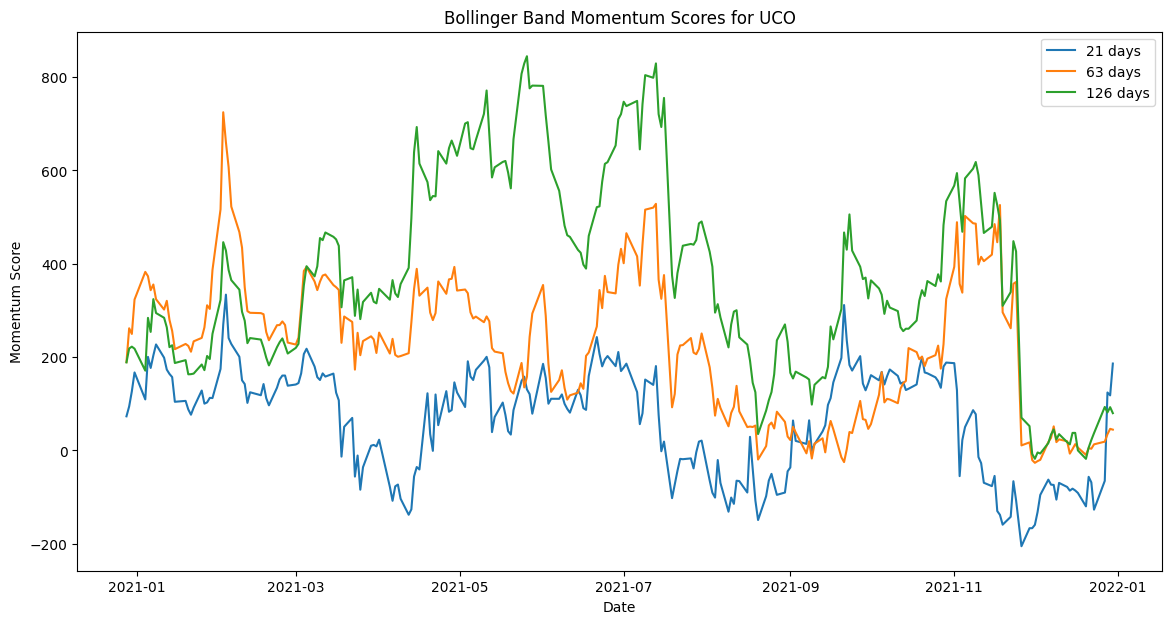

In [21]:
# Calculate Bollinger Band Momentum as per strategy
import numpy as np

# Parameters from strategy
momentum_periods = [21, 63, 126]
bb_period = 20
bb_std = 2.0

# Calculate momentum scores over time
momentum_scores = pd.DataFrame(index=close.index, columns=momentum_periods)

for i in range(bb_period + max(momentum_periods), len(close)):
    current_date = close.index[i]
    current_data = close.iloc[i - bb_period + 1 : i + 1]  # last bb_period days up to current
    current_price = close.iloc[i]['UCO']
    
    # Calculate BB
    middle_band = current_data['UCO'].mean()
    std_dev = current_data['UCO'].std()
    upper_band = middle_band + bb_std * std_dev
    lower_band = middle_band - bb_std * std_dev
    band_width = upper_band - lower_band
    
    for lookback in momentum_periods:
        if i >= lookback:
            historical_price = close.iloc[i - lookback]['UCO']
            price_change = current_price - historical_price
            if band_width > 0:
                bb_score = (price_change / (band_width / 2)) * 100
            else:
                bb_score = 0
            momentum_scores.loc[current_date, lookback] = bb_score

# Plot the momentum scores
plt.figure(figsize=(14,7))
for period in momentum_periods:
    plt.plot(momentum_scores[period], label=f'{period} days')
plt.title('Bollinger Band Momentum Scores for UCO')
plt.xlabel('Date')
plt.ylabel('Momentum Score')
plt.legend()
plt.show()